In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import tqdm.notebook as tqdm
from collections import Counter
import lemmy
plt.style.use("classic")

import requests
from bs4 import BeautifulSoup
import re
import json

#Text Analysis
import nltk
from nltk.corpus import stopwords

import spacy
import da_core_news_md as da
import lemmy.pipe

try:
    nlp = da.load()
    pipe = lemmy.pipe.load('da')
    nlp.add_pipe(pipe, after='tagger')
except ValueError:
    None

%matplotlib inline

### Group 2

In [68]:
def houses_boliga():
    """
    Returns a list of all ids for houses on Boliga.dk
    """
    #Setting up list
    house_id = list()
    url = "https://www.boliga.dk/resultat?"
    #Finding number of pages on Boliga
    response = requests.get(url)
    html = response.text
    soup = BeautifulSoup(html,"html.parser")
    ids = soup.find_all("a",{"class":"page-button"})
    
    max_pages = int(ids[-2].text)
    #Going through each list and getting the id for all houses on page. 30 per page.
    for i in tqdm(range(1,max_pages)):
        new_url = url + f"page={i}"
        response = requests.get(new_url)
        html = response.text
        soup = BeautifulSoup(html,"html.parser")
        ids = soup.find_all("a",{"class":"house-list-item"})
        link_houses = list()
        #Appending 30 ids to list, making a try command to work around a possible fail.
        for link in ids:
            try:
                link_houses.append(re.findall("(/\d{4,}/)",link["href"])[0].replace("/",""))
            except:
                continue
        #Extending the final list
        house_id.extend(link_houses)
        
    print("Hentet alle ids")
    
    return house_id

def get_info(id_list):
    
    """
    Take an list with ids of houses on boliga and gets specific data about these ids from Boligas API
    """
    #Setting up list with df and the desired values
    all_df = list()
    new_keys = ["registeredArea","downPayment","estateUrl","currentArchiveId","forSaleNowId",
                "foreclosureId","selfsaleEstateId","cleanStreet","estateId","latitude","longitude",
               "propertyType","priceChangePercentTotal","energyClass","price","rooms","size","lotSize",
               "floor","buildYear","city","isActive","municipality","zipCode","street",
                "squaremeterPrice","daysForSale","createdDate","basementSize","views"]
    
    #Going through each house id, to get the corresponding API Request
    for house_id in id_list:
        response = requests.get(f'https://api.boliga.dk/api/v2/estate/{house_id}')
        response = response.json()
        #Making sure we only get values we need
        df_dict = {key: response[key] for key in new_keys}
        df = pd.DataFrame(df_dict,index=[0])
        #Appending each house to a list
        all_df.append(df)
        
    #Concating all house df together
    df = pd.concat(all_df,axis=0,ignore_index=True)
    
    return df

def get_reviews(df):
    """
    Loops through all links of dataframe, scrapes the top links and return a dataframe with the body text.
    """
    bodys = list()
    #Finding all real estates agtens who has more than a 100 houses for sale
    for value in df["estateUrl"].values:
        estates.append(value[8:15])
    numbers = dict(Counter(estates))
    over_100 = dict() 
    for key, value in numbers.items():
        if value > 100:
            over_100[key] = value
    
    #Looping through all links and finds corresponding body text
    for link in tqdm(df["estateUrl"].values):
        i += 1
        body_len_prior = len(bodys)
        try:
            #Creating request
            response = requests.get(link)
            html = response.text
            soup = BeautifulSoup(html,"html.parser")
            
            #Different real estate agents demand different find_all
            if link[8:15] =="home.dk": #Home
                ids = soup.find_all("div",{"class":"text"},"p")
                bodys.extend([x.p.text.replace("\n","").strip().lower() for x in ids[0:1] if len(x)>1])
            elif link[8:15] =="ww.skbo": #skbolig
                ids = soup.find_all("div",{"class":"listing-text"})
                bodys.extend([sk.text.replace("\n","").replace("\r","").strip().lower() for sk in ids[0:1] if len(sk)>1])
            elif link[8:15] == "www.nyb": #Nybolig
                ids = soup.find_all("div",{"class":"foldable-spot__container"})
                bodys.extend([ny.text.replace("\n","").strip().lower() for ny in ids[0:1] if len(ny)>1])
            elif link [8:15] == "ww.elto": #Eltoft Nielsen
                ids = soup.find_all("br")
                bodys.extend([elto.text.replace("\n","").strip().lower() for elto in ids[0:1] if len(elto)>1])
            elif link[8:15] == "www.cla": #Claus Borg
                ids = soup.find_all("div",{"id":"case_content"})
                bodys.extend([cla.text.replace("\n","").strip().lower() for cla in ids[0:1] if len(cla)>1])
            elif link[8:15] == "www.lok": #Lokalbolig
                ids = soup.find_all("div",{"class":"css-s7itso eknr0ef1"})
                bodys.extend([lok.text.replace("\n","").strip() for lok in ids[0:1] if len(lok)>1])
            elif link[8:15] == "www.edc": #EDC Bolig
                ids = soup.find_all("div",{"class":"description"})
                bodys.extend([edc.text.replace("\n","").strip().lower() for edc in ids[0:1] if len(edc)>1])
            elif link[8:15] == "adamsch": #Adam Schnack
                ids = soup.find_all("div",{"class":"listing-text"})
                bodys.extend([adam.text.replace("\n","").strip().lower() for adam in ids[0:1] if len(adam)>1])
            elif link[8:20] == "www.estate.d": #Estate
                ids = soup.find_all("div",{"class":"property-description"})
                bodys.extend([est.text.replace("\n","").strip().lower() for est in ids[0:1] if len(est)>1])
            elif link[8:15] == "www.bri": #Brikk Ejendomme
                ids = soup.find_all("div",{"class":"prop-user-content"})
                bodys.extend([bri.text.replace("\n","").strip().lower() for bri in ids[0:1] if len(bri)>1])
            elif link[8:15] == "www.rea": #Realmæglerne
                ids = soup.find_all("div",{"class":"text-full"})
                bodys.extend([rea.text.replace("\n","").strip().lower() for rea in ids[0:1] if len(rea)>1])
            elif link[8:15] == "danboli": #Danbolig
                ids = soup.find_all("div",{"class":"db-description-block"})
                bodys.extend([dan.text.replace("\n","").strip().lower() for dan in ids[0:1] if len(dan)>1])
            elif link[8:15] == "ww.lili": #Lillenhof
                ids = soup.find_all("div",{"class":"inner"})
                bodys.extend([dan.text.replace("\n","").strip().lower() for dan in ids[0:1] if len(dan)>10])
            elif link[8:15] == "bjornby":
                ids = soup.find_all("div",{"class":"content d-md-block d-none wrap-content"})
                bodys.extend([bjor.text.replace("\n","").strip() for bjor in ids[0:1] if len(bjor)>10])
            elif link[8:15] == 'www.hov': #Hovmand
                ids = soup.find_all("div",{"class":"column"})
                bodys.extend([hov.text.replace("\n","").strip() for hov in ids[0:1] if len(hov)>1])
            elif link[8:15] == 'ww.jesp': #Jesper Nielsen
                ids = soup.find_all("div",{"class":"case-description"})
                bodys.extend([jesp.text.replace("\n","").strip() for jesp in ids[0:1] if len(jesp)>1])
            elif link[8:15] == "www.sel": #Selvsalg
                ids = soup.find_all("div",{"class":"tab-pane active fade in"})
                bodys.extend([selv.text.replace("\n","").strip() for selv in ids[0:1] if len(selv)>1])
            elif link[8:15] == "www.bol": #Bolig
                ids = soup.find_all("div",{"class":"description col-md-16"})
                bodys.extend([bol.text.replace("\n","").strip() for bol in ids[0:1] if len(bol)>1])
            elif link[8:15] == 'www.joh': #Johns
                ids = soup.find_all("div",{"class":"column"})
                bodys.extend([john.text.replace("\n","").strip() for john in ids[0:1] if len(john)>1])
            elif link[8:15] == "racking": #Robinhus
                ids = soup.find_all("div",{"class":"text-container"})
                bodys.extend([robin.text.replace("\n","").strip() for robin in ids[0:1] if len(robin)>1])
            elif link[8:15] == "www.min": #minbolighandel
                ids = soup.find_all("div",{"class":"description col-md-16"})
                bodys.extend([minb.text.replace("\n","").strip() for minb in ids[0:1] if len(minb)>1])
            elif link[8:15] == "ww.unni": #Unnibolig
                ids = soup.find_all("div",{"class":"column"})
                bodys.extend([un.text.replace("\n","").strip() for un in ids[0:1] if len(un)>1])
            elif link[8:15] == "www.sdb": #Sdb bolig
                ids = soup.find_all("div",{"class":"column"})
                bodys.extend([un.text.replace("\n","").strip() for un in ids[0:1] if len(un)>1])
            elif link[8:15] == "ww.land":#Landobolig
                ids = soup.find_all("div",{"class":"col-md-8"})
                bodys.extend([land.text.replace("\n","").strip() for land in ids[0:1] if len(land)>1])
            elif link[8:15] == "www.ber": #Bermistof
                ids = soup.find_all("div",{"class":"column"})
                bodys.extend([ber.text.replace("\n","").strip() for ber in ids[0:1] if len(ber)>1])
            elif link [8:20] == 'www.carlsber': #Carlsberg Byen
                ids = soup.find_all("div",{"itemprop":"description"})
                bodys.extend([car.text.replace("\n","").strip() for car in ids[0:1] if len(car)>1])
            elif link[8:15] == "www.car": #Carsten Nordbo
                ids = soup.find_all("div",{"class":"description col-md-16"})
                bodys.extend([car.text.replace("\n","").strip() for car in ids[0:1] if len(car)>1])
            elif link[8:15] == 'ww.agri': 
                ids = soup.find_all("div",{"class":"col-md-8 col-sm-7 hidden-xs text-box desktop"})
                bodys.extend([agr.text.replace("\n","").strip() for agr in ids[0:1] if len(agr)>1])
            elif link[8:15] == "www.pla":#Place2Live
                ids = soup.find_all("div",{"class":"col-lg-16"})
                bodys.extend([pla.text.replace("\n","").strip() for pla in ids[0:1] if len(pla)>1])
            elif link[8:15] == "www.vil": #Villadsenbolig
                ids = soup.find_all("div",{"class":"description col-md-16"})
                bodys.extend([vil.text.replace("\n","").strip() for vil in ids[0:1] if len(vil)>1])
            elif link[8:15] == 'maegler': #Mæglerhuset
                ids = soup.find_all("div",{"class":"case-text"})
                bodys.extend([mae.text.replace("\n","").strip() for mae in ids[0:1] if len(mae)>1])
            elif link[8:15] == 'ww.thom': #ThomasJørgensen
                ids = soup.find_all("div",{"class":"description col-md-16"})
                bodys.extend([thom.text.replace("\n","").strip() for thom in ids[0:1] if len(thom)>1])
            elif link[8:15] == 'www.htb': #HTbolig
                ids = soup.find_all("div",{"class":"left-side global-style"})
                bodys.extend([htb.text.replace("\n","").strip() for htb in ids[0:1] if len(htb)>1])
            elif link[8:15] == 'ww.boli': #Boligone
                ids = soup.find_all("div",{"class":"first-col"})
                bodys.extend([bol.text.replace("\n","").strip() for bol in ids[0:1] if len(bol)>1])
            elif link[8:15] == "www.mæg":#Mæglerringen
                ids = soup.find_all("div",{"class":"first-col"})
                bodys.extend([ma.text.replace("\n","").strip() for ma in ids[0:1] if len(ma)>1])
            elif link[8:15] == "ww.vest":
                ids = soup.find_all("div",{"class":"first-col"})
                bodys.extend([vest.text.replace("\n","").strip() for vest in ids[0:1] if len(vest)>1])
            elif link[8:15] == "www.tho": #Thorregård
                ids = soup.find_all("div",{"class":"annonce rammebaggrund"})
                bodys.extend([th.text.replace("\n","").strip() for th in ids[0:1] if len(th)>1])
            elif link[8:15] == "byggegr": #Byggegrund
                ids = soup.find_all("div",{"class":"section section-12"})
                bodys.extend([byg.text.replace("\n","").strip() for byg in ids[0:1] if len(byg)>1])
            elif link[8:15] == "grundsa": #Grundsalg
                bodys.append(np.nan)
            elif link[8:15] == "rundsal": #Grundsalg
                bodys.append(np.nan)
            elif link[8:15] =="ww.paul": #paulun
                bodys.append(np.nan)
            else:
                bodys.append(np.nan)
        except:
            bodys.append(np.nan)
            print(link,"virkede ikke")
            continue
        
        #Making sure only one inqury is added
        body_len_after = len(bodys)
        fixed_change = body_len_prior + 1
        
        try:
            bodys = bodys[0:fixed_change]
        except:
            None
            
        #Adding the id
        if body_len_after == body_len_prior + 1:
            estate_ids.append(df[df["estateUrl"]==link]["currentArchiveId"].values[0])
    
    print(len(estate_ids))
    print(len(bodys))
    bodys_df = pd.DataFrame({"currentArchiveId":estate_ids,"body":bodys})
    
    return bodys_df

def find_realtors(df):
    """
    This function finds all realtors, who has more that 100 houses for sale.
    Used to find the structure for all realtors of relevance
    """
    realtors_link = list()
    #Finds all real estate agents with more than a 100 houses for sale
    estates = list()
    for value in df["estateUrl"].values:
        estates.append(value[8:15])
    numbers = dict(Counter(estates))

    over_100 = dict() 
    for key, value in numbers.items():
        if value > 100:
            over_100[key] = value
    already_accounted = list()
    #Looping through all links and returns links of one of the 100.
    for link in tqdm.tqdm(df["estateUrl"].values):        
        if link[8:15] in over_100.keys():
            if link[8:15] not in already_accounted:
                print(link,"not in loop")
                print(link[8:15])
                realtors_link.append(link[8:15])
                already_accounted.append(link[8:15])

    return realtors_link
    
def add_keyattr(df):
    """
    This function adds the key attributions to dataframe
    """
    
    key_attr = pd.read_csv("keywords.csv",sep=";") #Getting keyword file
    added_words = pd.read_csv("bodys.csv") #Getting bodys
    
    df = df.join(added_words,on="currentArchiveId")
    
    #Finding all words corresponding to group
    ref_list = [key_attr.loc[(key_attr["group"] == "view_list")|(key_attr["group_2"] == "view_list")|\
                         (key_attr["group_3"] == "view_list"), "word"],
                key_attr.loc[(key_attr["group"] == "nature_list")|(key_attr["group_2"] == "nature_list")|\
                         (key_attr["group_3"] == "nature_list"), "word"],
                key_attr.loc[(key_attr["group"] == "interior_list")|(key_attr["group_2"] == "interior_list")|\
                         (key_attr["group_3"] == "interior_list"), "word"],
                key_attr.loc[(key_attr["group"] == "location_list")|(key_attr["group_2"] == "location_list")|\
                         (key_attr["group_3"] == "location_list"), "word"],
               key_attr.loc[(key_attr["group"] == "other_list")|(key_attr["group_2"] == "other_list")|\
                         (key_attr["group_3"] == "other_list"), "word"]]
    
    #Generation dict for attr
    dict_att = {"view":list(),
                "nature":list(),
                "interior":list(),
                "location":list(),
               "other":list()}
    
    for body in df["bodys"].tolist():
        #Generating string
        nouns = preprocess_text(body)
        for value,cross_list in zip(dict_att.values(),ref_list):
            #Generating view key attr
            value.append(len(list(set(nouns).intersection(cross_list))))
    
    #Add key attributes
    added_df = pd.DataFrame(dict_att)
    df = df.join(added_df)
    df.drop("bodys",axis=1,inplace=True)
    
    return df

def preprocess_csv(csv):
    """
    This function loads our dataset made from Boliga, staionsdata and real estate agents 
    and preproccesses it.
    """
    df = pd.read_csv(csv,index_col="Unnamed: 0")
    y = df["price"]

    #Creating temp dataframes for dummy
    temp_type = df["propertyType"]
    temp_komm = df["municipality"]
    temp_floor = df["floor"]
    temp_distance = df["dist_station"]
        
    #Making room per sqm
    df["rooms_per_sqm"] = (df["rooms"]/df["size"]).replace(np.inf,0)
    
    #Removing houses not placed in Denmark
    df = df[(df["latitude"]<60) & (df["latitude"]>53) & (df["longitude"]>7) & (df["longitude"]<16)]
    
    
    #Adding keyattr to df
    df_text = add_keyattr(df)
    
    #Generating dummy variables - Distance Station
    dis_df = pd.cut(temp_distance,4,labels=["very_close","close","semi","far_away"])
    dis_df = pd.get_dummies(dis_df)
    df= df.join(dis_df)
    df_text = df_text.join(dis_df)
    
    #Generating dummy variables - Property type
    housing_type={1:'villa',2:'raekkehuse', 3:'ejerlejlighed',4:'fritidshus', 5:'andel',6:'landejendom', 
              7:'helrsgrund',8:'fritidsgrund', 9:'villalejlighed',10:'andet_1',11:"andet_2",12:"andet_3"}
    dummy_df = pd.get_dummies(temp_type.replace(housing_type))   
    df = df.join(dummy_df)
    df_text = df_text.join(dummy_df)
    #df.rename(columns = housing_type,inplace=True)
    
    #Dropping all None house
    df = df[(df["helrsgrund"] == 0) & (df["andet_3"] == 0)]
    df_text = df_text[(df_text["helrsgrund"] == 0) & (df_text["andet_3"] == 0)]
    
    #Generation dummies variables - Kommune
    dummy_mun = pd.get_dummies(temp_komm,prefix="mun_")
    df = df.join(dummy_mun)
    df_text = df_text.join(dummy_mon)
    
    #Generation dummies variables - Floor
    dummy_floor = pd.get_dummies(temp_floor.map(str),prefix="flr_")
    df = df.join(dummy_floor)
    df_text = df_text.join(dummy_floor)
    
    #Creating X and y, making sure they have the same index
    #Dropping all non essential columns
    X = df.drop(["downPayment","estateUrl","currentArchiveId","forSaleNowId",
            "foreclosureId","cleanStreet","estateId","latitude","longitude","energyClass",
           "price","city","isActive","municipality","zipCode","street","createdDate",
            "squaremeterPrice","region","kommune_nr","rooms","propertyType","kommune_navn",
            "floor",'dist_station'],axis=1).dropna(axis=0).values
    X_text = df_text.drop(["downPayment","estateUrl","currentArchiveId","forSaleNowId",
            "foreclosureId","cleanStreet","estateId","latitude","longitude","energyClass",
           "price","city","isActive","municipality","zipCode","street","createdDate",
            "squaremeterPrice","region","kommune_nr","rooms","propertyType","kommune_navn",
            "floor",'dist_station'],axis=1).dropna(axis=0).values
    #Dropping all NA
    #df.dropna(inplace=True,axis=0)
    
    index_for_y = df.drop(["downPayment","estateUrl","currentArchiveId","forSaleNowId",
            "foreclosureId","cleanStreet","estateId","latitude","longitude","energyClass",
           "price","city","isActive","municipality","zipCode","street","createdDate",
            "squaremeterPrice","region","kommune_nr","rooms","propertyType","kommune_navn",
            "floor",'dist_station'],axis=1).dropna(axis=0)
    
    y = y[df_index_for_y.index].values
    
    index_for_y_text = df_text.drop(["downPayment","estateUrl","currentArchiveId","forSaleNowId",
            "foreclosureId","cleanStreet","estateId","latitude","longitude","energyClass",
           "price","city","isActive","municipality","zipCode","street","createdDate",
            "squaremeterPrice","region","kommune_nr","rooms","propertyType","kommune_navn",
            "floor",'dist_station'],axis=1).dropna(axis=0)
    y = y[index_for_y_text.index].values
    
    return X, X_text, y, y_text, df

def preprocess_text(string,nlp=nlp):
    """
    This function takes a string and returns a list with all noun from string lemmatized
    """

    #Removing everything but words
    string = re.sub(r'[^\w\s]','',string)
    
    #Removing stopwords
    stop_words_list = stopwords.words("danish")
    string = [i for i in nltk.word_tokenize(string.lower()) if i not in stop_words_list]
    string = " ".join(string)
    
    #Getting all nounce and takes the lemmatized version
    string = nlp(string)
    nouns = [word._.lemmas[0] for word in string if word.pos_ == "NOUN"]
    
    return nouns

def words_count(list_of_strings):
    """
    This function takes a list of strings and returns a dict with counts of each word
    """
    #Creates a dict which counts words
    sentences = list_of_strings
    counts = dict(Counter(sentences))
    
    return counts

def keywords(body):
    """
    This function takes a list of different strings and returns a dataframe with each word 
    and word count.
    """
    
    #Setting up list
    word_list = list()
    
    #Looping through each body text
    for bodys in tqdm.tqdm(body):
        string = preprocess_text(bodys[0])
        word_list.extend(string)
    
    #Creating a dataframes with each word and corresponding count
    dict_count = words_count(word_list)
    df = pd.DataFrame({"word":list(dict_count.keys()),
                        "count":list(dict_count.values())}).set_index("word")
    
    #Getting the 300 largest counts returns the keywords used for key attr list
    return df
    
def add_lonlat(df,df_station):
    """
    This function takes two df and returns the distance between two locations of the dataframes location columns
    """
    
    min_dist = list()
    
    #Looping through each location
    for location in tqdm(df["location"]):
        distance = list()
        #Making a a cross reference between location and each station
        for lon,lat in zip(df_station["lon"],df_station["lat"]):
            distance.append(geodesic((lat,lon), location).km)
        #Appending the smallest distance
        min_dist.append(min(distance))
        
    df["dist_station"] = min_dist
    
    return df

def next_preprocess(X,y,random_state=None):
    """
    This function us used for ML. This takes X and y as input and transforms the variables
    so that dummy variables is not transformed.
    """
    
    #Preparing transformer, for all but dummy variables
    ct = ColumnTransformer([("poly", PolynomialFeatures(degree=3),[0,11]),
                    ("scaler",StandardScaler(),[0,11])],remainder="passthrough")

    #Splitting the dataset
    X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                        random_state=random_state,
                                                        test_size=0.33)
    #Fits and transform
    X_test = ct.fit_transform(X_test)
    X_train = ct.transform(X_train)
    
    
    return X_train, X_test, y_train, y_test


In [69]:
X, X_text, y, y_text, df = preprocess_csv("house_data_final.csv") #Running the csv file through the preprocess function 
df.head()

,registeredArea,downPayment,estateUrl,currentArchiveId,forSaleNowId,foreclosureId,selfsaleEstateId,cleanStreet,estateId,latitude,...,flr__29.0,flr__3.0,flr__4.0,flr__46.0,flr__5.0,flr__6.0,flr__7.0,flr__8.0,flr__9.0,flr__nan
0,68,225000,https://home.dk/boligkatalog/koebenhavn/1051/e...,1676546,0,0,0,Nyhavn,0,55.68044,...,0,0,0,0,0,0,0,0,0,1
1,78,430000,https://www.nybolig.dk/ejerlejlighed/1051/nyha...,1688236,0,0,0,Nyhavn,0,55.68038,...,0,0,1,0,0,0,0,0,0,0
2,117,460000,http://www.skbolig.dk/sag.asp?sagsnr=221920&mg...,1672807,0,0,0,Nyhavn,0,55.67950,...,0,0,0,0,0,0,0,0,0,1
3,146,550000,http://www.skbolig.dk/sag.asp?sagsnr=333420&mg...,1694633,0,0,0,Nyhavn,0,55.67977,...,0,0,0,0,0,0,0,0,0,0
4,182,625000,http://www.skbolig.dk/sag.asp?sagsnr=331320&mg...,1689738,0,0,0,Nyhavn,0,55.67973,...,0,1,0,0,0,0,0,0,0,0


# Descriptive Statistics

In [64]:
#Table
print(df[["price","size","squaremeterPrice","rooms","daysForSale"]].describe().to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &         price &          size &  squaremeterPrice &         rooms &   daysForSale \\
\midrule
count &  4.745600e+04 &  47456.000000 &      4.745600e+04 &  47456.000000 &  47456.000000 \\
mean  &  2.403305e+06 &    140.295495 &      1.782059e+04 &      4.523862 &    277.736493 \\
std   &  2.475032e+06 &     99.063665 &      2.716779e+04 &      1.967140 &    428.078648 \\
min   &  0.000000e+00 &      0.000000 &      0.000000e+00 &      0.000000 &      0.000000 \\
25\%   &  1.045000e+06 &     95.000000 &      8.200750e+03 &      3.000000 &     50.000000 \\
50\%   &  1.795000e+06 &    131.000000 &      1.355200e+04 &      4.000000 &    133.000000 \\
75\%   &  2.995000e+06 &    172.000000 &      2.261600e+04 &      5.000000 &    335.000000 \\
max   &  8.500000e+07 &   9073.000000 &      3.750000e+06 &     56.000000 &   4981.000000 \\
\bottomrule
\end{tabular}



## Plots - Descriptive Statistics

In [ ]:
a=df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.004, color='mediumblue')
plt.ylim(ymax = 58.2, ymin = 54)
plt.xlim(xmax = 16, xmin = 7)
plt.title('Houses for sale in Denmark')
for pos in ['right','top']:
    a.spines[pos].set_visible(False)

y=df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.9,
 c="price", cmap=plt.get_cmap("jet"), colorbar=True, )
plt.legend()
plt.ylim(ymax = 56.25, ymin = 55.5)
plt.xlim(xmax = 12.7, xmin = 12.4)
plt.title('Copenhagen')
for pos in ['right','top']:
    y.spines[pos].set_visible(False)

z=df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.9,
 c="price", cmap=plt.get_cmap("jet"), colorbar=True, 
)
plt.legend()
plt.ylim(ymax = 56.25, ymin = 54.5)
plt.xlim(xmax = 12.7, xmin = 10.9)
plt.title('Zealand and Falster')

for pos in ['right','top']:
    z.spines[pos].set_visible(False)

In [ ]:
df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.9,
 c="daysForSale", cmap=plt.get_cmap("jet"), colorbar=True, )
plt.legend()
plt.ylim(ymax = 58.2, ymin = 54)
plt.xlim(xmax = 16, xmin = 7)
plt.title('Days for sale, Denmark')
for pos in ['right','top']:
    y.spines[pos].set_visible(False)
df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.9,
 c="daysForSale", cmap=plt.get_cmap("jet"), colorbar=True, 
)
plt.legend()
plt.ylim(ymax = 56.3, ymin = 54.4)
plt.xlim(xmax = 12.7, xmin = 10.9)
plt.title('Days for sale, Zealand')
for pos in ['right','top']:
    z.spines[pos].set_visible(False)

In [151]:
from wordcloud import WordCloud
from PIL import Image

def create_wordcloud(df):
        
    keywords = pd.read_csv("/Users/frederikfindsen/Documents/økonomi/Sommerskole - ISD/SODAS2020_group2/keywords.csv",
                      delimiter =";")
    
    no_list = keywords["word"][keywords["group"]=="no_list"].tolist()
    total_list = list()
    df["price_range"] = pd.cut(df["price"],3,labels=["Expensive","Medium","Cheap"])
    
    for price_range in df["price_range"].unique():    
        list_w = list()
        for body in df["body"][df["price_range"]==price_range].values:
            list_w.extend(preprocess_text(body))
        list_w = [w for w in list_w if w not in no_list]
        total_list.append(list_w)
    
    fig, axes = plt.subplots(1,3)
    i = list(range(3))
    for value_list, i, name in zip(total_list,i,df["price_range"].unique()):
        mask = np.array(Image.open("/Users/frederikfindsen/Documents/økonomi/Sommerskole - ISD/SODAS2020_group2/house_draw.png"))
        wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="white",
                      mask=mask).generate(" ".join(v for v in value_list))
        
        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].axis("off")
        axes[i].set_title()
    
    fig.tight_layout()

# Machine Learning
In the following section we are implementing and validation various Machine Learning models in order to identify the best possible model.

In [89]:
##Importing all relevant packages for the Machine Learning
#Packages for preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#Packages for validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.model_selection import validation_curve

#Packages for regression models
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [90]:
def next_preprocess(X,y,random_state=None,text=False):
    """
    This function makes the necessary preprocessing procedures for our data.
    For every thing but our Dummy variables. Returns tran and test data.
    """
    #Preparing transformer, for all but dummy variables
    if text == False:
        ct = ColumnTransformer([("poly", PolynomialFeatures(degree=3),[0,10]),
                    ("scaler",StandardScaler(),[0,10])],remainder="passthrough")
    if text == True: #Check at der er 15 koloner som ikke er dummy!!
        ct = ColumnTransformer([("poly", PolynomialFeatures(degree=3),[0,15]),
                    ("scaler",StandardScaler(),[0,15])],remainder="passthrough")

    #Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                        random_state=random_state,
                                                        test_size=0.3)
    #Fitting to test and transforms train
    X_test = ct.fit_transform(X_test)
    X_train = ct.transform(X_train)
    
    
    return X_train, X_test, y_train, y_test

def display_scores(scores):
    print("Scores",scores)
    print("Mean:",scores.mean())
    print("Standard Deviation",scores.std())

In [91]:
X_train, X_test, y_train, y_test = next_preprocess(X,y) #Splitting the data into train and test
Xt_train , Xt_test, yt_train, yt_test = next_preprocess(X_text,y_text,text=True)
y=y/1e+6 # Making the price in mio DKK

In [92]:
ct = ColumnTransformer([("poly", PolynomialFeatures(degree=3),[0,10]),
                    ("scaler",StandardScaler(),[0,10])],remainder="passthrough")
X_fitted = ct.fit_transform(X)
ct = ColumnTransformer([("poly", PolynomialFeatures(degree=3),[0,10]),
                    ("scaler",StandardScaler(),[0,15])],remainder="passthrough") #CHECK AT DET ER !%
Xt_fitted = ct.fit_transform(X_text)

## Non text data - ML

## Linear Regression
In the following section a standard linear regression model will be implemented

In [ ]:
lin_reg = LinearRegression()
#Cross_val_score splits the data in K-folds by itself
lin_scores = cross_val_score(lin_reg,X_fitted,y,scoring="neg_mean_squared_error",cv=10)

rmse_scores = np.sqrt(-lin_scores)
display_scores(rmse_scores)

## Lasso Regression
In the following section a Lasso regression model will be implemented

In [93]:
las_reg = Lasso(tol=0.01,alpha=166)
las_scores = cross_val_score(las_reg,X_fitted,y,scoring="neg_mean_squared_error",cv=10)

las_rmse_scores = np.sqrt(-las_scores)
display_scores(las_rmse_scores)


Scores [3.86800483e-06 4.88519088e-06 1.58124540e-06 1.93339906e-06
 1.91372048e-06 1.83785428e-06 1.68531573e-06 1.98305227e-06
 1.56747330e-06 1.62692777e-06]
Mean: 2.2882183993901975e-06
Standard Deviation 1.0780617879622276e-06


## Random Forest Regression
In the following section a Random forest regression model will be implemented

In [48]:
ran_reg = RandomForestRegressor(max_features=6,n_estimators=58) #Getting best estimators from gridsearch
ran_scores = cross_val_score(ran_reg,X,y,scoring="neg_mean_squared_error",cv=10)

lin_rmse_scores = np.sqrt(-ran_scores)
display_scores(lin_rmse_scores)

Scores [2.5120541  3.47928466 1.18354287 1.44141914 1.33331456 1.36396686
 1.02962232 1.36715608 0.9640153  1.0501955 ]
Mean: 1.5724571378516627
Standard Deviation 0.7594533003188758


## Decision Tree Regression
In the following section a Decision Tree regression model will be implemented

In [9]:
des_reg = DecisionTreeRegressor()
tree_scores = cross_val_score(des_reg,X,y,scoring="neg_mean_squared_error",cv=10)

tree_rmse_scores = np.sqrt(-tree_scores)
display_scores(tree_rmse_scores)

Scores [2.96121526 3.84172847 1.91591413 1.85621071 1.73629982 1.58112328
 1.28816535 1.81378853 1.52725955 1.44576994]
Mean: 1.9967475040121507
Standard Deviation 0.7523677163932851


In [17]:
X_train, X_test, y_train, y_test = next_preprocess(X,y)
ran_test = RandomForestRegressor(max_features=6,n_estimators=55)
ran_test.fit(X_train,y_train)
r2_score(y_test,ran_test.predict(X_test))

0.6703916855173625

## Text data - ML


## Linear Regression
In the following section a standard linear regression model will be implemented

In [ ]:
lin_reg = LinearRegression()
#Cross_val_score splits the data in K-folds by itself
lin_scores = cross_val_score(lin_reg,Xt_fitted,y,scoring="neg_mean_squared_error",cv=10)

rmse_scores = np.sqrt(-lin_scores)
display_scores(rmse_scores)

## Lasso Regression
In the following section a Lasso regression model will be implemented

In [93]:
las_reg = Lasso(tol=0.01,alpha=166)
las_scores = cross_val_score(las_reg,Xt_fitted,y,scoring="neg_mean_squared_error",cv=10)

las_rmse_scores = np.sqrt(-las_scores)
display_scores(las_rmse_scores)


Scores [3.86800483e-06 4.88519088e-06 1.58124540e-06 1.93339906e-06
 1.91372048e-06 1.83785428e-06 1.68531573e-06 1.98305227e-06
 1.56747330e-06 1.62692777e-06]
Mean: 2.2882183993901975e-06
Standard Deviation 1.0780617879622276e-06


## Random Forest Regression
In the following section a Random forest regression model will be implemented

In [48]:
ran_reg = RandomForestRegressor(max_features=6,n_estimators=58) #Getting best estimators from gridsearch
ran_scores = cross_val_score(ran_reg,Xt,y,scoring="neg_mean_squared_error",cv=10)

lin_rmse_scores = np.sqrt(-ran_scores)
display_scores(lin_rmse_scores)

Scores [2.5120541  3.47928466 1.18354287 1.44141914 1.33331456 1.36396686
 1.02962232 1.36715608 0.9640153  1.0501955 ]
Mean: 1.5724571378516627
Standard Deviation 0.7594533003188758


## Decision Tree Regression
In the following section a Decision Tree regression model will be implemented

In [9]:
des_reg = DecisionTreeRegressor()
tree_scores = cross_val_score(des_reg,Xt,y,scoring="neg_mean_squared_error",cv=10)

tree_rmse_scores = np.sqrt(-tree_scores)
display_scores(tree_rmse_scores)

Scores [2.96121526 3.84172847 1.91591413 1.85621071 1.73629982 1.58112328
 1.28816535 1.81378853 1.52725955 1.44576994]
Mean: 1.9967475040121507
Standard Deviation 0.7523677163932851


In [17]:
X_train, X_test, y_train, y_test = next_preprocess(X_text,y_text,text=True)
ran_test = RandomForestRegressor(max_features=6,n_estimators=55)
ran_test.fit(X_train,y_train)
r2_score(y_test,ran_test.predict(X_test))

0.6703916855173625

### Getting best estimators

In [215]:
#Finding the best estimators for RandomForest
param_grid = {"n_estimators":list(range(50,60))}
ran_search = GridSearchCV(ran_reg,param_grid,cv=9,scoring="neg_mean_squared_error")
ran_search.fit(X_train,y_train)

GridSearchCV(cv=9, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features=6,
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=54, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=Non

In [216]:
ran_search.best_params_

{'n_estimators': 58}

In [100]:
param_grid_las = {"alpha":list(range(0,50))}
ran_search_las = GridSearchCV(las_reg,param_grid_las,cv=9,scoring="neg_mean_squared_error")
ran_search_las.fit(X_train,y_train)

ran_search_las.best_params_

/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41698.92533395536, tolerance: 1728.3134654261212
  positive)
/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression

/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49509.03840065113, tolerance: 1757.002364650126
  positive)
/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69589.14840164254, tolerance: 1769.6458598085244
  positive)
/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67903.1959752762, tolerance: 1763.106617755932
  positive)
/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not 

/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60110.228007164784, tolerance: 1763.106617755932
  positive)
/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60377.77096472367, tolerance: 1794.5546597704758
  positive)
/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8927.436182860198, tolerance: 1734.4279093225114
  positive)
/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did n

/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3976.1565838667157, tolerance: 1734.4279093225114
  positive)
/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52005.501371011735, tolerance: 1728.3134654261212
  positive)
/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51705.58717595144, tolerance: 1773.5870511926707
  positive)
/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did

/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44603.45626224831, tolerance: 1773.5870511926707
  positive)
/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60518.876876937786, tolerance: 1793.6325759996312
  positive)
/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2099.0323582918645, tolerance: 1763.7412177657325
  positive)
/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did

/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30845.131846444674, tolerance: 1773.5870511926707
  positive)
/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51177.283595731016, tolerance: 1793.6325759996312
  positive)
/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2512.558451983263, tolerance: 1757.002364650126
  positive)
/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did 

/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25734.689580455597, tolerance: 1769.6458598085244
  positive)
/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20402.1817579106, tolerance: 1763.106617755932
  positive)
/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20058.523415152755, tolerance: 1794.5546597704758
  positive)
/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did n

/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28676.21315726758, tolerance: 1793.6325759996312
  positive)
/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15521.058409269986, tolerance: 1769.6458598085244
  positive)
/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11392.89779802227, tolerance: 1763.106617755932
  positive)
/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did n

/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5416.662479088525, tolerance: 1773.5870511926707
  positive)
/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14051.840981455694, tolerance: 1793.6325759996312
  positive)
/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7375.084268114908, tolerance: 1769.6458598085244
  positive)
/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did 

/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82875.91242927802, tolerance: 1793.6325759996312
  positive)
/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79763.92762035216, tolerance: 1734.4279093225114
  positive)
/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80488.8634487373, tolerance: 1728.3134654261212
  positive)
/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did no

/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82165.80339776746, tolerance: 1794.5546597704758
  positive)
/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5511.028708354439, tolerance: 1793.6325759996312
  positive)
/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28024.208719968825, tolerance: 1769.6458598085244
  positive)
/Users/frederikfindsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did 

{'alpha': 0}

### Plotting the validation curve

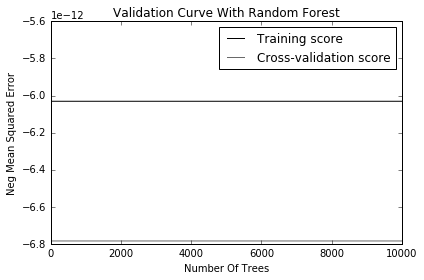

In [99]:
param_range = np.logspace(-4,4,10)
#Making validation curve
train_scores, test_scores = validation_curve(Lasso(), 
                                             X, 
                                             y, 
                                             param_name="alpha", 
                                             param_range=param_range,
                                             cv=3, 
                                             scoring="neg_mean_squared_error")
#Calculating Mean
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# Create plot

plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Neg Mean Squared Error")
plt.tight_layout()

plt.legend(loc="best")